# Identify the problem

As a data scientist in a financial company's risk management department, the task at hand is to analyze data related to a food trading company. The data provided includes information about the products sold, such as product number, weight, and retail prices, as well as store features such as size and location. The goal of this analysis is to clean and interpret the data, make predictions and present the results to non-technical customers. The problem is to understand the performance of the food trading company by examining the products that were sold nationwide last month.

In [1]:
#Import the Libraries
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from math import sqrt
import matplotlib.pyplot as plt
import copy
from scipy import stats
import matplotlib.ticker as ticker
import math
import seaborn as sns
%matplotlib inline

F:\Conda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Gathering

The second stage in this process is to gather the necessary data for the analysis, which includes information about products and store attributes, collected from the company's risk management department.

In [2]:
df = pd.read_csv('dataset.csv')

# Data Cleaning and Preprocessing: 

 The data cleaning and preprocessing stage is crucial for the success of the analysis, as it ensures that the data is accurate, complete, and in a format that can be used for modeling. This stage includes filling missing values, checking and removing outliers, duplicates, and incorrect entries, and transforming categorical data into numerical data. For this problem, the data was relatively easy to clean, and the preprocessing steps included filling missing values based on other columns, dropping unnecessary columns, standardizing categories and encoding the data into numerical values, and normalizing the data.

In [3]:
df.head()

,I_Id,I_W,I_Fat_C,I_Vis,I_MRP_JD,I_category,I_MRP_US,O_Id,O_Establ_Y,O_Size,I_Recalled,O_Loc_T,O_T,I_O_Sales
0,FDA15,9.30,Low Fat,0.016172,225.644532,Dairy,317.8092,OUT049,2009,Medium,NO,Tier 1,Carrefour,3915.1380
1,DRC01,5.92,Regular,0.019403,82.551132,Soft Drinks,116.2692,OUT018,2019,Medium,YES,Tier 3,C-Town,623.4228
2,FDN15,17.50,Low Fat,0.016885,148.828780,Meat,209.6180,OUT049,2009,Medium,NO,Tier 1,Carrefour,2277.2700
3,FDX07,19.20,Regular,0.000000,177.567450,Fruits and Vegetables,250.0950,OUT010,2008,NaN,NO,Tier 3,Family Basket,912.3800
4,NCD19,8.93,Low Fat,0.000000,86.521594,Household,121.8614,OUT013,1997,High,NO,Tier 3,Carrefour,1174.7052


In [4]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        sum_mean = df[col].isnull().mean()
        l.append([col,dtypes,nunique,sum_null,sum_mean])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null','sum_mean']
    return df_check 

In [5]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,I_Id,object,1559,0,0.000000
1,I_W,float64,415,1463,0.171653
2,I_Fat_C,object,5,0,0.000000
3,I_Vis,float64,7880,0,0.000000
4,I_MRP_JD,float64,5938,0,0.000000
5,I_category,object,16,0,0.000000
6,I_MRP_US,float64,5938,0,0.000000
7,O_Id,object,10,0,0.000000
8,O_Establ_Y,int64,9,0,0.000000
9,O_Size,object,3,2410,0.282764


In [6]:
len(df)

8523

In [7]:
df['I_O_Sales'] = df['I_O_Sales']*0.709 # convert the label into JDs

In [8]:
df.groupby('I_Id')['I_W'].apply(lambda x: x.fillna(x.mean())).value_counts()

12.150    103
17.600     98
13.650     89
15.100     86
11.800     83
         ... 
10.800      1
6.385       1
18.100      1
8.355       1
7.470       1
Name: I_W, Length: 497, dtype: int64

In [9]:
df['I_W'] = df['I_W'].fillna(df.groupby('I_Id')['I_W'].transform('mean'))

In [10]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,I_Id,object,1559,0,0.000000
1,I_W,float64,446,4,0.000469
2,I_Fat_C,object,5,0,0.000000
3,I_Vis,float64,7880,0,0.000000
4,I_MRP_JD,float64,5938,0,0.000000
5,I_category,object,16,0,0.000000
6,I_MRP_US,float64,5938,0,0.000000
7,O_Id,object,10,0,0.000000
8,O_Establ_Y,int64,9,0,0.000000
9,O_Size,object,3,2410,0.282764


In [11]:
df['I_W'] = df['I_W'].fillna(df['I_W'].mean())

# Feature Engineering

In [12]:
df['Product_category'] = df['I_Id'].str[:3]
df['Product_ID'] = df['I_Id'].str[3:]
first_column = df.pop('Product_category')
df.insert(0, 'Product_category', first_column)
second_column = df.pop('Product_ID')
df.insert(1, 'Product_ID', second_column)
df = df.drop(columns= ['I_Id'])

In [13]:
df.head()

,Product_category,Product_ID,I_W,I_Fat_C,I_Vis,I_MRP_JD,I_category,I_MRP_US,O_Id,O_Establ_Y,O_Size,I_Recalled,O_Loc_T,O_T,I_O_Sales
0,FDA,15,9.30,Low Fat,0.016172,225.644532,Dairy,317.8092,OUT049,2009,Medium,NO,Tier 1,Carrefour,2775.832842
1,DRC,01,5.92,Regular,0.019403,82.551132,Soft Drinks,116.2692,OUT018,2019,Medium,YES,Tier 3,C-Town,442.006765
2,FDN,15,17.50,Low Fat,0.016885,148.828780,Meat,209.6180,OUT049,2009,Medium,NO,Tier 1,Carrefour,1614.584430
3,FDX,07,19.20,Regular,0.000000,177.567450,Fruits and Vegetables,250.0950,OUT010,2008,NaN,NO,Tier 3,Family Basket,646.877420
4,NCD,19,8.93,Low Fat,0.000000,86.521594,Household,121.8614,OUT013,1997,High,NO,Tier 3,Carrefour,832.865987


In [14]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,Product_category,object,71,0,0.000000
1,Product_ID,object,60,0,0.000000
2,I_W,float64,447,0,0.000000
3,I_Fat_C,object,5,0,0.000000
4,I_Vis,float64,7880,0,0.000000
5,I_MRP_JD,float64,5938,0,0.000000
6,I_category,object,16,0,0.000000
7,I_MRP_US,float64,5938,0,0.000000
8,O_Id,object,10,0,0.000000
9,O_Establ_Y,int64,9,0,0.000000


In [15]:
df['I_Fat_C'] = df['I_Fat_C'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

In [16]:
df['I_Fat_C'].value_counts()

Low Fat    5517
Regular    3006
Name: I_Fat_C, dtype: int64

In [17]:
check(df[['O_Id','O_Size']])

,column,dtypes,nunique,sum_null,sum_mean
0,O_Id,object,10,0,0.000000
1,O_Size,object,3,2410,0.282764


In [18]:
df.head()

,Product_category,Product_ID,I_W,I_Fat_C,I_Vis,I_MRP_JD,I_category,I_MRP_US,O_Id,O_Establ_Y,O_Size,I_Recalled,O_Loc_T,O_T,I_O_Sales
0,FDA,15,9.30,Low Fat,0.016172,225.644532,Dairy,317.8092,OUT049,2009,Medium,NO,Tier 1,Carrefour,2775.832842
1,DRC,01,5.92,Regular,0.019403,82.551132,Soft Drinks,116.2692,OUT018,2019,Medium,YES,Tier 3,C-Town,442.006765
2,FDN,15,17.50,Low Fat,0.016885,148.828780,Meat,209.6180,OUT049,2009,Medium,NO,Tier 1,Carrefour,1614.584430
3,FDX,07,19.20,Regular,0.000000,177.567450,Fruits and Vegetables,250.0950,OUT010,2008,NaN,NO,Tier 3,Family Basket,646.877420
4,NCD,19,8.93,Low Fat,0.000000,86.521594,Household,121.8614,OUT013,1997,High,NO,Tier 3,Carrefour,832.865987


In [19]:
check(df[df['O_Size'] == 'Small'])

,column,dtypes,nunique,sum_null,sum_mean
0,Product_category,object,71,0,0.0
1,Product_ID,object,60,0,0.0
2,I_W,float64,411,0,0.0
3,I_Fat_C,object,2,0,0.0
4,I_Vis,float64,2207,0,0.0
5,I_MRP_JD,float64,2156,0,0.0
6,I_category,object,16,0,0.0
7,I_MRP_US,float64,2156,0,0.0
8,O_Id,object,3,0,0.0
9,O_Establ_Y,int64,3,0,0.0


In [20]:
df[df['O_Size'] == 'Small'].O_Id.value_counts()

OUT046    930
OUT035    930
OUT019    528
Name: O_Id, dtype: int64

In [21]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,Product_category,object,71,0,0.000000
1,Product_ID,object,60,0,0.000000
2,I_W,float64,447,0,0.000000
3,I_Fat_C,object,2,0,0.000000
4,I_Vis,float64,7880,0,0.000000
5,I_MRP_JD,float64,5938,0,0.000000
6,I_category,object,16,0,0.000000
7,I_MRP_US,float64,5938,0,0.000000
8,O_Id,object,10,0,0.000000
9,O_Establ_Y,int64,9,0,0.000000


# O_Size column, which the null values in the Carrefour store and in Family Basket store

Carrefour store, all the null values was in Tier 2 and the remained Tier 2 that Carrefour store is locatted are **small**, for this I am goint to fill the missing value for the Carrefour store with **small**

*Family Basket store*, for the O_Size column which means the city or town in which the mall is located, but in 1995 the stores sales product ranges from 140JD-900JD after its located to another city which is Tier 3 (tier 3 cities are considered to be smaller or less developed than tier 1 and tier 2 cities), in 2008,  its incomes remained in the same range from 140JD-900JD, which means that the  Family Basket store remained in the same size **small**

In [22]:
for i in range(len(df)):
    if df['O_Id'].iloc[i] == 'OUT045' or 'OUT035' or 'OUT017' or  'OUT010' and df['O_Loc_T'].iloc[i] == 'Tier 2' and df['O_T'].iloc[i] == 'Carrefour' and df['O_T'].iloc[i] == 'Family Basket':
        df.iloc[i] = df.iloc[i].fillna('Small')

In [23]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,Product_category,object,71,0,0.0
1,Product_ID,object,60,0,0.0
2,I_W,float64,447,0,0.0
3,I_Fat_C,object,2,0,0.0
4,I_Vis,float64,7880,0,0.0
5,I_MRP_JD,float64,5938,0,0.0
6,I_category,object,16,0,0.0
7,I_MRP_US,float64,5938,0,0.0
8,O_Id,object,10,0,0.0
9,O_Establ_Y,int64,9,0,0.0


In [24]:
df['O_Size'].isnull().sum() # All Clear!!

0

In [25]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,Product_category,object,71,0,0.0
1,Product_ID,object,60,0,0.0
2,I_W,float64,447,0,0.0
3,I_Fat_C,object,2,0,0.0
4,I_Vis,float64,7880,0,0.0
5,I_MRP_JD,float64,5938,0,0.0
6,I_category,object,16,0,0.0
7,I_MRP_US,float64,5938,0,0.0
8,O_Id,object,10,0,0.0
9,O_Establ_Y,int64,9,0,0.0


In [26]:
df.head()

,Product_category,Product_ID,I_W,I_Fat_C,I_Vis,I_MRP_JD,I_category,I_MRP_US,O_Id,O_Establ_Y,O_Size,I_Recalled,O_Loc_T,O_T,I_O_Sales
0,FDA,15,9.30,Low Fat,0.016172,225.644532,Dairy,317.8092,OUT049,2009,Medium,NO,Tier 1,Carrefour,2775.832842
1,DRC,01,5.92,Regular,0.019403,82.551132,Soft Drinks,116.2692,OUT018,2019,Medium,YES,Tier 3,C-Town,442.006765
2,FDN,15,17.50,Low Fat,0.016885,148.828780,Meat,209.6180,OUT049,2009,Medium,NO,Tier 1,Carrefour,1614.584430
3,FDX,07,19.20,Regular,0.000000,177.567450,Fruits and Vegetables,250.0950,OUT010,2008,Small,NO,Tier 3,Family Basket,646.877420
4,NCD,19,8.93,Low Fat,0.000000,86.521594,Household,121.8614,OUT013,1997,High,NO,Tier 3,Carrefour,832.865987


In [27]:
df['Product_ID'] = df['Product_ID'].astype('int64')
df['O_Establ_Y'] = df['O_Establ_Y'].astype('object')

In [28]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,Product_category,object,71,0,0.0
1,Product_ID,int64,60,0,0.0
2,I_W,float64,447,0,0.0
3,I_Fat_C,object,2,0,0.0
4,I_Vis,float64,7880,0,0.0
5,I_MRP_JD,float64,5938,0,0.0
6,I_category,object,16,0,0.0
7,I_MRP_US,float64,5938,0,0.0
8,O_Id,object,10,0,0.0
9,O_Establ_Y,object,9,0,0.0


# Exploration Data Analysis (EDA)

I used EDA to understand the distribution of the products and store features and identify any outliers in the data. I also used visualization techniques to understand the relationships between different columns and gain insights into the meaning of the data. This helped me to better understand the data and prepare for the next stages of the data science process.

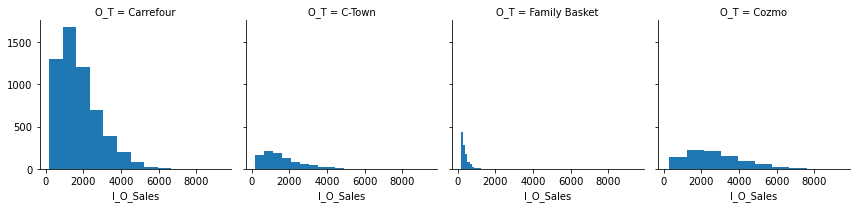

In [29]:
g = sns.FacetGrid(data=df,col='O_T')
g.map(plt.hist,'I_O_Sales')

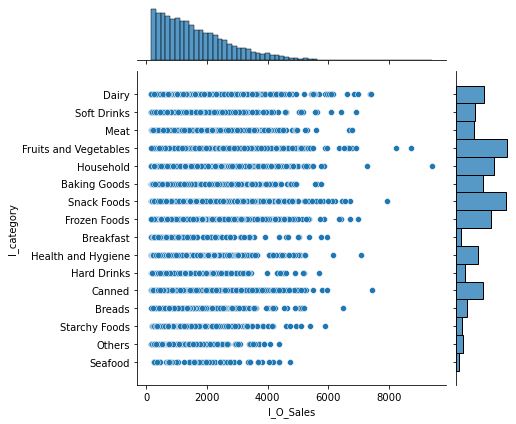

In [30]:
sns.jointplot(x='I_O_Sales',y='I_category',data=df)

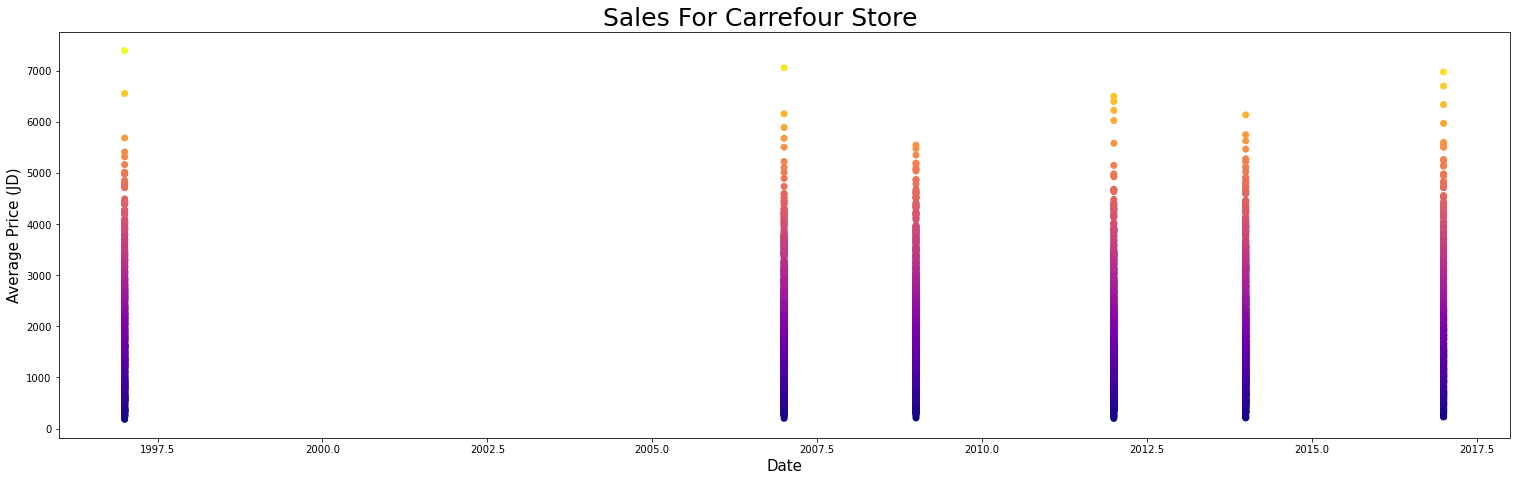

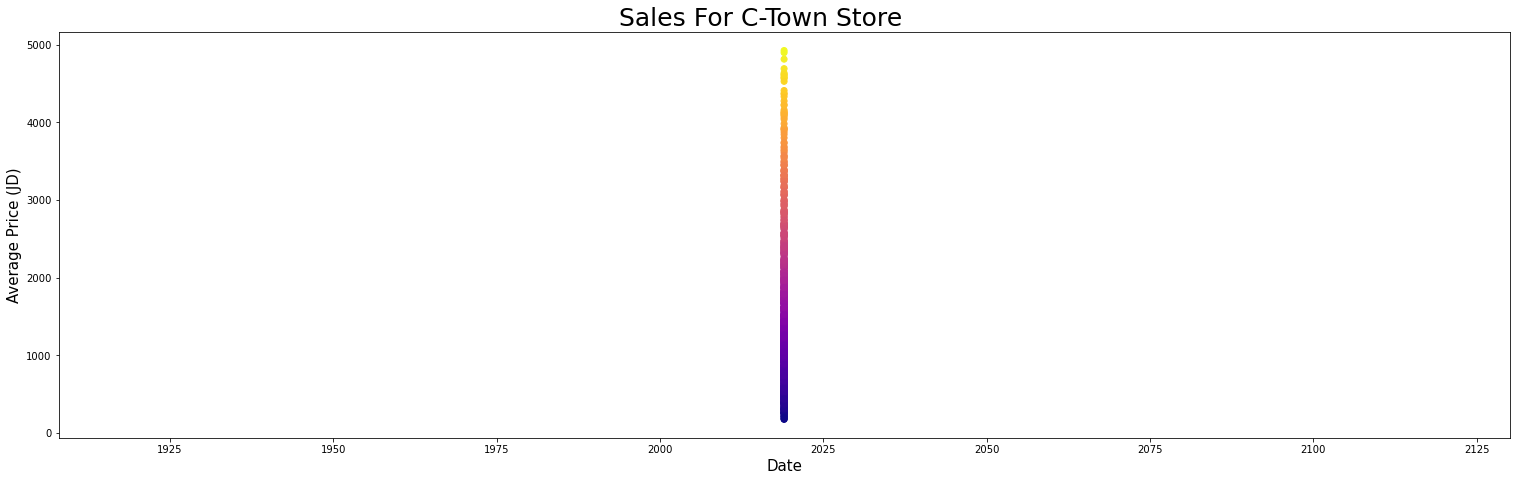

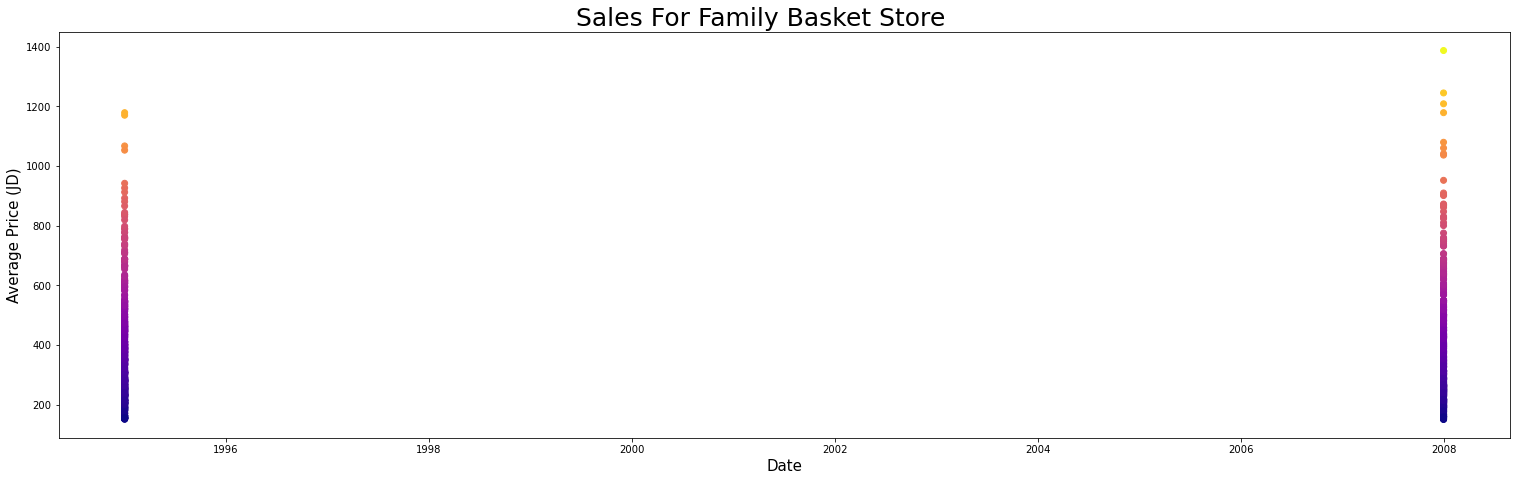

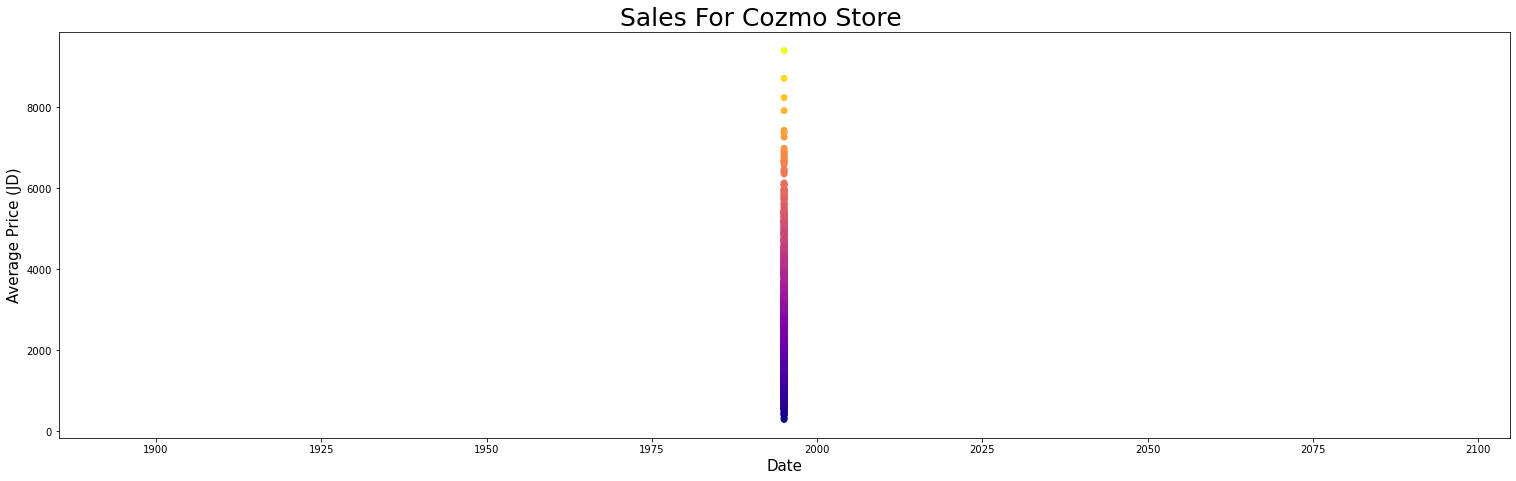

In [31]:
stores = ['Carrefour', 'C-Town', 'Family Basket', 'Cozmo']

# Average price of Organic Avocados over time
for store in stores:
    mask = df['O_T']== store
    plt.rc('figure', titlesize=50)
    fig = plt.figure(figsize = (26, 7))
    fig.suptitle(f'Sales For {store} Store', fontsize=25)
    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.93)

    dates = df[mask]['O_Establ_Y'].tolist()
    avgPrices = df[mask]['I_O_Sales'].tolist()

    plt.scatter(dates, avgPrices, c=avgPrices, cmap='plasma')
    ax.set_xlabel('Date',fontsize = 15)
    ax.set_ylabel('Average Price (JD)', fontsize = 15)
    plt.show()


O_Id plot >>

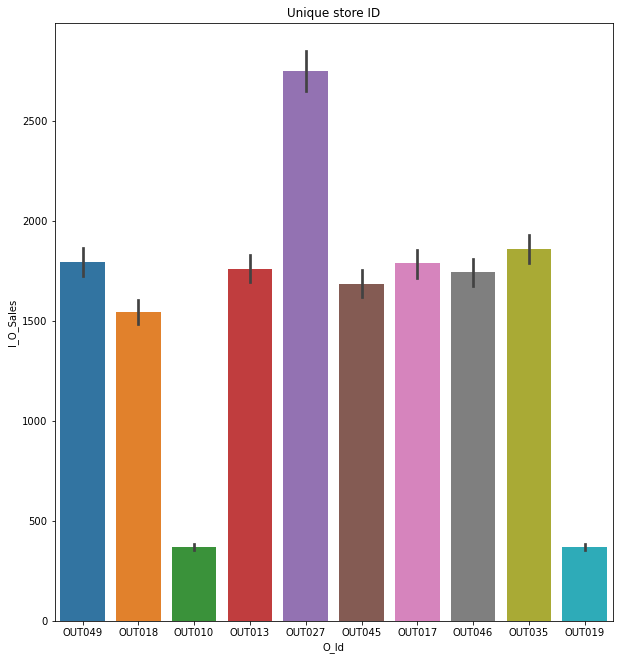

In [32]:
plt.figure(figsize=(10,11))
plt.title("Unique store ID")
Av= sns.barplot(x="O_Id",y="I_O_Sales",data= df)

Column Name >> I_Fat_C


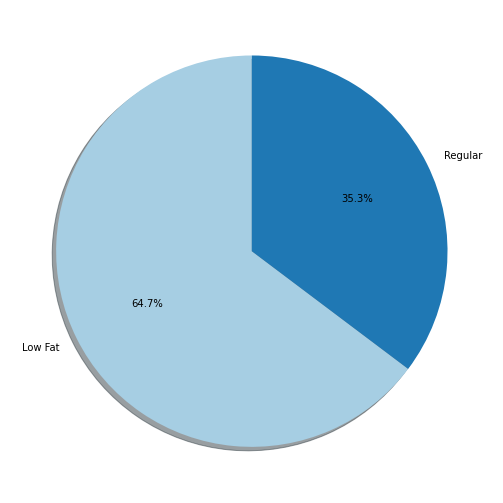

Column Name >> O_Establ_Y


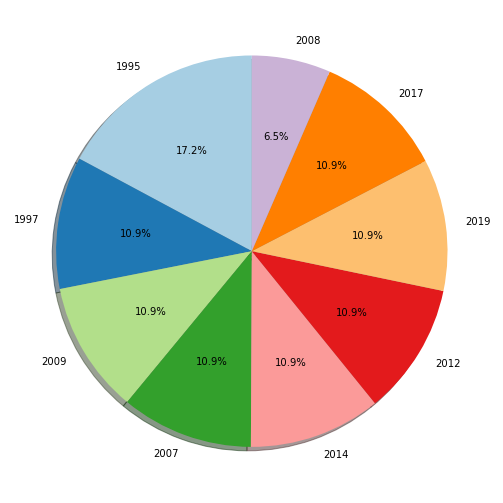

Column Name >> O_Size


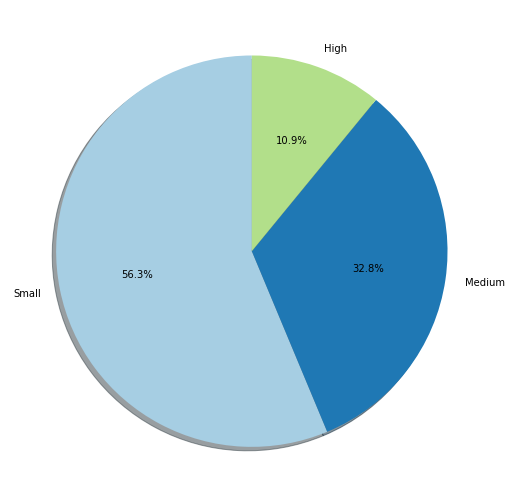

Column Name >> I_Recalled


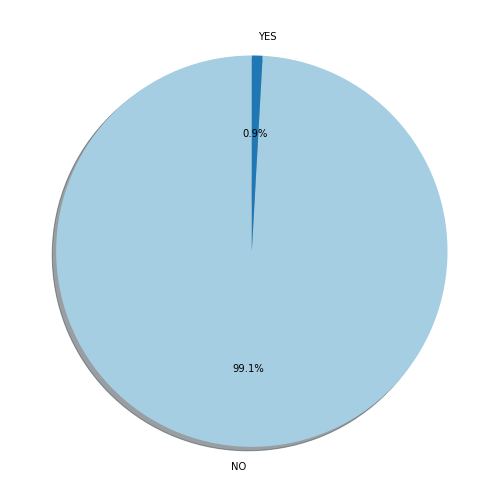

Column Name >> O_Loc_T


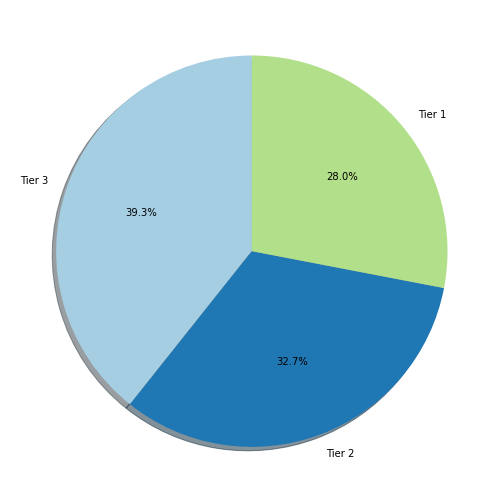

In [33]:
p = ['I_Fat_C', 'O_Establ_Y', 'O_Size', 'I_Recalled', 'O_Loc_T']
#sns.set(style='darkgrid', font_scale=1)

for i in p:
    pt = df[i].value_counts()
    labels=pt.index
    sizes=pt.values
    plt.figure(figsize=(12,9))
    colors = sns.color_palette('Paired')
    plt.pie(sizes,labels=labels,autopct='%1.1f%%',
        shadow=True,colors=colors,startangle=90)
    print(f"Column Name >> {i}")
    plt.show()

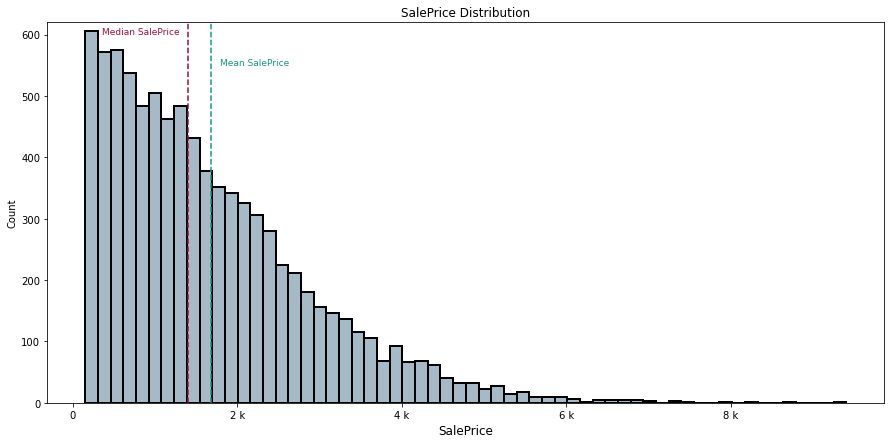

In [34]:
mean_SalePrice = df[["I_O_Sales"]].mean().squeeze()
median_SalePrice = df[["I_O_Sales"]].median().squeeze()

plt.figure(figsize=(15, 7))

histplt = sns.histplot(
    data=df,
    x="I_O_Sales",
    color="#4f758f",
    bins=60,
    alpha=0.5,
    lw=2,
)
histplt.set_title("SalePrice Distribution", fontsize=12)
histplt.set_xlabel("SalePrice", fontsize=12)

plt.axvline(x=mean_SalePrice, color="#14967f", ls="--")
plt.axvline(x=median_SalePrice, color="#9b0f33", ls="--")
plt.text(mean_SalePrice +120, 550, "Mean SalePrice", fontsize=9, color="#14967f")

plt.text(median_SalePrice-1050, 600, "Median SalePrice", fontsize=9, color="#9b0f33")
histplt.xaxis.set_major_formatter(ticker.EngFormatter())

plt.ylim(0, 620)
plt.show()

 Data is positively skewed (Right Skewed Distribution).

* The outliers located in the right side, although we do not know how many outliers are there.

* We may use log transformation to reduces the skewness

* The majority of data points are clustered between 100 JD and 4k JD


let's check the the Normality...

In [35]:
df["I_O_Sales_log"] = np.log(df["I_O_Sales"])

In [36]:
def prob_plot(tq_var1, tq_var2):

    plt.subplot(2, 2, 1)
    tq_var1_hist = sns.histplot(
        df[tq_var1], kde=True, color="#03396c", line_kws={"lw": 2}
    )
    tq_var1_hist.xaxis.set_major_formatter(ticker.EngFormatter())
    tq_var1_hist.set_title("(" + tq_var1 + ") " + "Distributions", fontsize=10)
    ######################
    ax = plt.subplot(2, 2, 2)
    stats.probplot(df[tq_var1], plot=plt)
    ax.get_lines()[0].set_marker("o")
    ax.get_lines()[0].set_markerfacecolor("#343d46")
    ax.get_lines()[0].set_markeredgecolor("#343d46")
    ax.get_lines()[0].set_markersize(5.0)
    ax.get_lines()[1].set_color("#f01c58")
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title("Probability Plot " + "(" + tq_var1 + ")", fontsize=10)
    #####################
    plt.subplot(2, 2, 3)
    tq_var1_hist = sns.histplot(
        df[tq_var2], kde=True, color="#03396c", line_kws={"lw": 2}
    )
    tq_var1_hist.xaxis.set_major_formatter(ticker.EngFormatter())
    tq_var1_hist.set_title("(" + tq_var2 + ") " + "Distributions", fontsize=10)
    #####################
    ax = plt.subplot(2, 2, 4)
    stats.probplot(df[tq_var2], plot=plt)
    ax.get_lines()[0].set_marker("o")
    ax.get_lines()[0].set_markerfacecolor("#343d46")
    ax.get_lines()[0].set_markeredgecolor("#343d46")
    ax.get_lines()[0].set_markersize(5.0)
    ax.get_lines()[1].set_linewidth(3.0)
    ax.get_lines()[1].set_color("#f01c58")
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_title("Probability Plot " + "(" + tq_var2 + ")", fontsize=10)

    plt.tight_layout(pad=1)
    shapiro_test_tq_var1 = stats.shapiro(df[tq_var1])
    shapiro_test_tq_var2 = stats.shapiro(df[tq_var2])
    return print("(" + tq_var1 + ")--->", shapiro_test_tq_var1), print(
        "(" + tq_var2 + ")--->", shapiro_test_tq_var2
    )

F:\Conda\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(I_O_Sales)---> ShapiroResult(statistic=0.9094115495681763, pvalue=0.0)
(I_O_Sales_log)---> ShapiroResult(statistic=0.9742761850357056, pvalue=1.6454549690302633e-36)


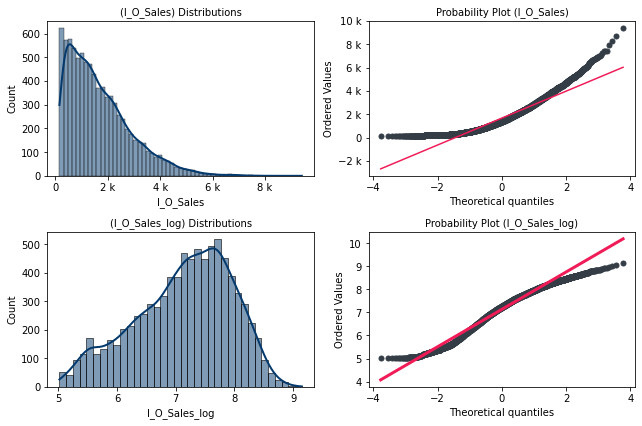

In [37]:
plt.figure(figsize=(9, 6))
prob_plot("I_O_Sales", "I_O_Sales_log")
plt.show()

** We have done a log transformation "I_O_Sales_log" to the target variable "I_O_Sales" which reduces the Skewness. And we can say that it became more or less a normally distributed variable, however Since the p-value in Shapiro Result is less than .05, so we can reject the null hypothesis of the Shapiro-Wilk test, this means we have a piece of sufficient evidence to consider that the sample data does not come from a normal distribution.

F:\Conda\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(I_MRP_US)---> ShapiroResult(statistic=0.9715957641601562, pvalue=5.630310170454441e-38)
(I_MRP_US_log)---> ShapiroResult(statistic=0.9611969590187073, pvalue=8.716076448100362e-43)


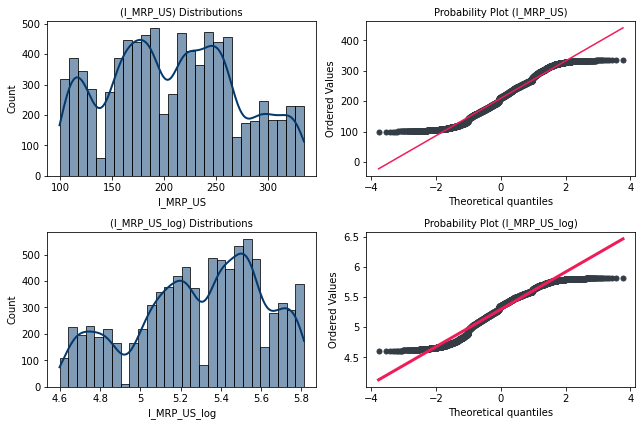

In [38]:
df['I_MRP_US_log'] = np.log(df['I_MRP_US'])
plt.figure(figsize=(9, 6))
prob_plot("I_MRP_US", "I_MRP_US_log")
plt.show()

In [39]:
df = df.drop(columns= ["I_O_Sales_log", "I_MRP_US_log"])

In [40]:
df['O_T'] = df['O_T'].map({'Carrefour': 0, 'Family Basket': 1, 'Cozmo' : 2, 'C-Town': 3 })

In [41]:
df.head()

,Product_category,Product_ID,I_W,I_Fat_C,I_Vis,I_MRP_JD,I_category,I_MRP_US,O_Id,O_Establ_Y,O_Size,I_Recalled,O_Loc_T,O_T,I_O_Sales
0,FDA,15,9.30,Low Fat,0.016172,225.644532,Dairy,317.8092,OUT049,2009,Medium,NO,Tier 1,0,2775.832842
1,DRC,1,5.92,Regular,0.019403,82.551132,Soft Drinks,116.2692,OUT018,2019,Medium,YES,Tier 3,3,442.006765
2,FDN,15,17.50,Low Fat,0.016885,148.828780,Meat,209.6180,OUT049,2009,Medium,NO,Tier 1,0,1614.584430
3,FDX,7,19.20,Regular,0.000000,177.567450,Fruits and Vegetables,250.0950,OUT010,2008,Small,NO,Tier 3,1,646.877420
4,NCD,19,8.93,Low Fat,0.000000,86.521594,Household,121.8614,OUT013,1997,High,NO,Tier 3,0,832.865987


In [42]:
df['I_Recalled'] = df['I_Recalled'].replace({'NO': 0 , 'YES': 1})

In [43]:
label_encoder = LabelEncoder()

ordinal_data = ['I_Fat_C', 'O_Size', 'O_Loc_T','O_Establ_Y']
nominal_data = ['Product_category', 'I_category', 'O_Id']

# for the ordinal data
for column in ordinal_data:
    df[column] = label_encoder.fit_transform(df[column])
    
# for the nominal data
enc = TargetEncoder(cols= nominal_data)
df = enc.fit_transform(df, df['I_O_Sales'])

F:\Conda\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
F:\Conda\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [44]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,Product_category,float64,71,0,0.0
1,Product_ID,int64,60,0,0.0
2,I_W,float64,447,0,0.0
3,I_Fat_C,int32,2,0,0.0
4,I_Vis,float64,7880,0,0.0
5,I_MRP_JD,float64,5938,0,0.0
6,I_category,float64,16,0,0.0
7,I_MRP_US,float64,5938,0,0.0
8,O_Id,float64,10,0,0.0
9,O_Establ_Y,int32,9,0,0.0


In [45]:
df.head()

,Product_category,Product_ID,I_W,I_Fat_C,I_Vis,I_MRP_JD,I_category,I_MRP_US,O_Id,O_Establ_Y,O_Size,I_Recalled,O_Loc_T,O_T,I_O_Sales
0,1798.715616,15,9.30,0,0.016172,225.644532,1710.492701,317.8092,1792.603436,4,1,0,0,0,2775.832842
1,1562.161119,1,5.92,1,0.019403,82.551132,1550.236820,116.2692,1542.428606,8,1,1,2,3,442.006765
2,1816.454351,15,17.50,0,0.016885,148.828780,1658.335339,209.6180,1792.603436,4,1,0,0,0,1614.584430
3,1738.314912,7,19.20,1,0.000000,177.567450,1750.527800,250.0950,368.220328,3,2,0,2,1,646.877420
4,1266.710860,19,8.93,0,0.000000,86.521594,1729.098069,121.8614,1757.607636,1,0,0,2,0,832.865987


In [46]:
#df['I_MRP_JD'] = df['I_MRP_JD']*1.4104372  

In [47]:
def z_score_normalization(X):
    mean_vals = X.mean(axis=0)
    std_vals = X.std(axis=0)

    X_normalized = (X - mean_vals) / std_vals

    return X_normalized


In [48]:
columns = ['Product_category', 'Product_ID', 'I_W', 'I_Vis', 'I_MRP_JD', 'I_category', 'I_MRP_US', 'O_Id', 'O_Establ_Y', 'O_Size', 'I_Recalled', 'O_Loc_T']        
df[columns] = z_score_normalization(df[columns])

In [49]:
#df['I_Vis'] = df['I_Vis']*1000
#df['I_MRP_US'] = scale_data(df['I_MRP_US'])

In [50]:
df.head()

,Product_category,Product_ID,I_W,I_Fat_C,I_Vis,I_MRP_JD,I_category,I_MRP_US,O_Id,O_Establ_Y,O_Size,I_Recalled,O_Loc_T,O_T,I_O_Sales
0,0.732121,-0.888812,-0.769734,0,-0.970340,1.747351,0.436273,1.747351,0.199488,0.076663,-0.664042,-0.094217,-1.369254,0,2775.832842
1,-0.658301,-1.700653,-1.497397,1,-0.907734,-1.488936,-1.487710,-1.488936,-0.221846,1.541692,-0.664042,10.612577,1.091505,3,442.006765
2,0.836386,-0.888812,0.995602,0,-0.956528,0.010040,-0.189912,0.010040,0.199488,0.076663,-0.664042,-0.094217,-1.369254,0,1614.584430
3,0.377097,-1.352721,1.361586,1,-1.283709,0.660011,0.916923,0.660011,-2.199400,-0.289594,0.799907,-0.094217,1.091505,1,646.877420
4,-2.394902,-0.656858,-0.849389,0,-1.283709,-1.399138,0.659644,-1.399138,0.140549,-1.022108,-2.127990,-0.094217,1.091505,0,832.865987


In [51]:
check(df)

,column,dtypes,nunique,sum_null,sum_mean
0,Product_category,float64,71,0,0.0
1,Product_ID,float64,60,0,0.0
2,I_W,float64,443,0,0.0
3,I_Fat_C,int32,2,0,0.0
4,I_Vis,float64,7880,0,0.0
5,I_MRP_JD,float64,5938,0,0.0
6,I_category,float64,16,0,0.0
7,I_MRP_US,float64,5938,0,0.0
8,O_Id,float64,10,0,0.0
9,O_Establ_Y,float64,9,0,0.0


In [52]:
df.head()

,Product_category,Product_ID,I_W,I_Fat_C,I_Vis,I_MRP_JD,I_category,I_MRP_US,O_Id,O_Establ_Y,O_Size,I_Recalled,O_Loc_T,O_T,I_O_Sales
0,0.732121,-0.888812,-0.769734,0,-0.970340,1.747351,0.436273,1.747351,0.199488,0.076663,-0.664042,-0.094217,-1.369254,0,2775.832842
1,-0.658301,-1.700653,-1.497397,1,-0.907734,-1.488936,-1.487710,-1.488936,-0.221846,1.541692,-0.664042,10.612577,1.091505,3,442.006765
2,0.836386,-0.888812,0.995602,0,-0.956528,0.010040,-0.189912,0.010040,0.199488,0.076663,-0.664042,-0.094217,-1.369254,0,1614.584430
3,0.377097,-1.352721,1.361586,1,-1.283709,0.660011,0.916923,0.660011,-2.199400,-0.289594,0.799907,-0.094217,1.091505,1,646.877420
4,-2.394902,-0.656858,-0.849389,0,-1.283709,-1.399138,0.659644,-1.399138,0.140549,-1.022108,-2.127990,-0.094217,1.091505,0,832.865987


In [53]:
#df[["I_O_Sales"]].describe().round()

<AxesSubplot:>

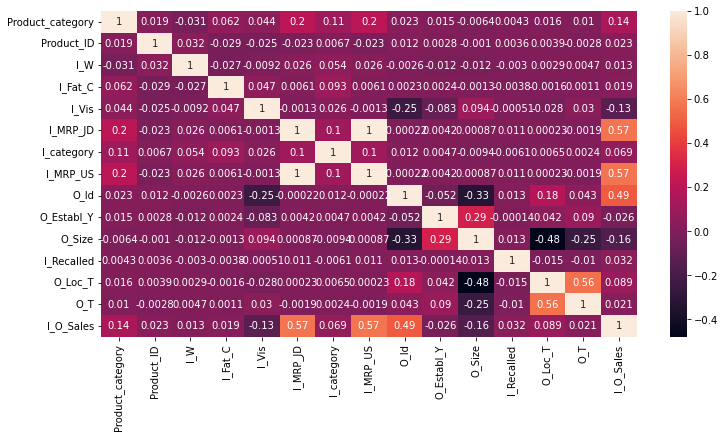

In [54]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),annot=True)

# Model Deployment

I applied multiple linear regression using both gradient descent and normal equation. I also implemented polynomial linear regression to improve the accuracy of my predictions. I evaluated the performance of all the models and selected the best one for my problem.

In [55]:
#X = df.drop(columns = ['I_O_Sales','I_MRP_US'])
#y = df['I_O_Sales']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#X_train = np.matrix(X_train.values)
#y_train = np.matrix(y_train.values)

In [56]:
X = df.drop(columns = ['I_O_Sales','I_MRP_JD'])
y = df['I_O_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [57]:
print("="*100)
print ('The shape of x_train is:', X_train.shape)
print ('The shape of y_train is: ', y_train.shape)
print ('Number of training examples (m):', len(X_train))
print("="*100)

The shape of x_train is: (5710, 13)
The shape of y_train is:  (5710,)
Number of training examples (m): 5710


In [58]:
X_train = np.array(X_train.values)  #The shape of x_train is: (5710, 13)
y_train = np.array(y_train.values)  # The shape of y_train is:  (1, 5710)
X_test = np.array(X_test.values)
y_test = np.array(y_test.values)

y_train = np.squeeze(np.asarray(y_train))

Calculate the Cost function >>

In [59]:
def compute_cost(X, y, theta):
    """
    Computes the cost for linear regression using theta as the parameter for linear regression.
    :param X: array-like or pandas DataFrame, features
    :param y: array-like or pandas DataFrame, target
    :param theta: array-like, linear regression parameters
    :return: float, cost
    """
    m = len(y)
    # Compute the predictions using theta
    y_pred = X @ theta
    # Compute the cost using the mean squared error formula
    cost = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
    return cost

Calculate the Gradient>> 

In [60]:
def calculate_gradient(X, y, theta):
    """
    Computes the gradient for linear regression using theta as the parameter for linear regression.
    :param X: array-like or pandas DataFrame, features
    :param y: array-like or pandas DataFrame, target
    :param theta: array-like, linear regression parameters
    :return: array-like, gradient
    """
    m = len(y)
    # Compute the predictions using theta
    y_pred = X @ theta
    # Compute the gradient using the gradient descent formula
    gradient = (1 / m) * X.T @ (y_pred - y)
    return gradient


Prediction Model >>

In [61]:
"""
    Makes predictions using linear regression model with theta as the parameters
    :param X: array-like or pandas DataFrame, features
    :param theta: array-like, linear regression parameters
    :return: array-like, predictions
    """
def predict(X, theta):
    return np.dot(X, theta)  # Compute the predictions using theta

Gradient Descent >>

In [62]:
def gradient_descent(X, y, theta, learning_rate, num_iters):
    """
    Perform gradient descent to optimize theta for linear regression
    :param X: array-like or pandas DataFrame, features
    :param y: array-like or pandas DataFrame, target
    :param theta: array-like, linear regression parameters
    :param learning_rate: float, learning rate for the gradient descent algorithm
    :param num_iters: int, number of iterations for the gradient descent algorithm
    :return: array-like, optimized theta
    """
    m = len(y)
    cost_history = np.zeros(num_iters)
    theta_history = np.zeros((num_iters, theta.shape[0]))
    for i in range(num_iters):
        error = X @ theta - y
        theta = theta - learning_rate * (1/m) * (X.T @ error)
        theta_history[i,:] = theta.T
        cost_history[i] = compute_cost(X, y, theta)
    return theta, cost_history, theta_history

Initial cost:  2178689.7337328177
Final cost:  326618.49396221194
Predictions:  [1146.26512077  567.51598383  704.00117087 ... 2264.98927551 2405.0365511
  613.66116984]


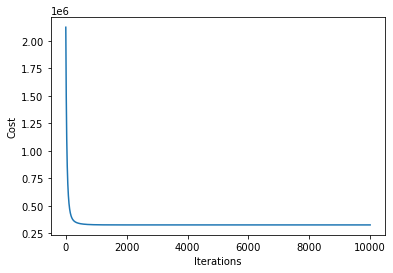

In [63]:
# Set seed for reproducibility
np.random.seed(0)
X = X_train
y = y_train

X = np.insert(X, 0, 1, axis=1)
theta = np.random.randn(14)
learning_rate = 0.01
num_iters = 10000

# Compute initial cost
cost = compute_cost(X, y, theta)
print("Initial cost: ", cost)

# Perform gradient descent
theta, cost_history, theta_history = gradient_descent(X, y, theta, learning_rate, num_iters)

# Compute final cost
cost = compute_cost(X, y, theta)
print("Final cost: ", cost)

# Make predictions
X_test = np.insert(X_test, 0, 1, axis=1)
y_pred = predict(X_test, theta)
print("Predictions: ", y_pred)

# Plot the cost over iterations of gradient descent
plt.plot(range(num_iters), cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()


Model Evaluation for Multipule Linear Regression using Gradient Descent >>

Mean Absolute Error: 574.4039703916508
Mean Squared Error: 605280.7953071062
Root Mean Squared Error: 777.9979404260054
R-Squared: 0.5703807355592521




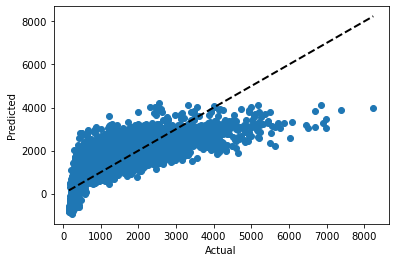

In [64]:
#Calculate evaluation measures
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

#Print the evaluation measures
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Squared:", r2)
print('\n')

# Plot the predicted vs actual values
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

Normal Equation >>

In [65]:
def Normal_equation(X, y):
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return theta

In [66]:
# Define feature and target variables
X = df.drop(columns = ['I_O_Sales','I_MRP_JD'])
y = df['I_O_Sales']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Convert Dataframe to numpy array
X_train, y_train, X_test, y_test = np.array(X_train.values), np.array(y_train.values), np.array(X_test.values), np.array(y_test.values)

# reshape y_train to be a vector of shape (5710,)
y_train = np.squeeze(np.asarray(y_train))

# Set seed for reproducibility
np.random.seed(0)

# Add column of ones to the X matrix
X_train = np.insert(X_train, 0, 1, axis=1)
X_test = np.insert(X_test, 0, 1, axis=1)

# Perform Normal Equation 
theta = Normal_equation(X_train,y_train)

# Make predictions
y_pred = predict(X_test, theta)
print("Predictions: ", y_pred)

Predictions:  [1146.26512475  567.51598579  704.00116746 ... 2264.98927355 2405.03655262
  613.66116597]


Model Evaluation for Normal Equation >>

Mean Absolute Error: 574.4039704184222
Mean Squared Error: 605280.7952504815
Root Mean Squared Error: 777.9979403896141
R-Squared: 0.5703807355994435




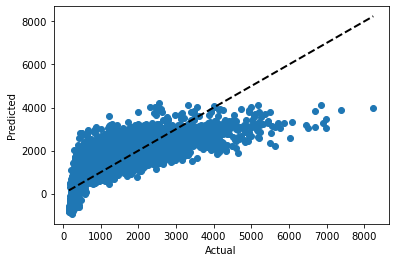

In [67]:
#Calculate evaluation measures
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

#Print the evaluation measures
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Squared:", r2)
print('\n')

# Plot the predicted vs actual values
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

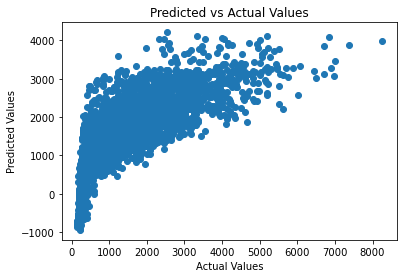

In [68]:
# Plot the predicted values against the actual values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

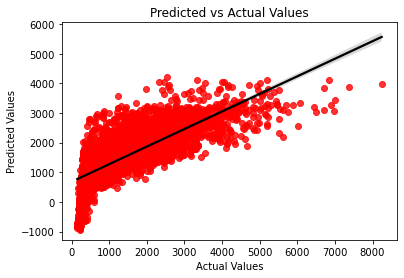

In [69]:
sns.regplot(x = y_test, y = y_pred, scatter_kws={'color':'red'}, line_kws={'color':'black'})
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

# Polynomial Multipule Linear Regression

In [70]:
def poly_features(X, degree):
    """
    Maps the original features to polynomial features of the specified degree
    """
    X_poly = X.copy()
    for i in range(2, degree+1):
        X_poly = np.column_stack((X_poly, np.power(X, i)))
    return X_poly

Predictions:  [1166.67286875  606.65572132  650.44514696 ... 2295.70565973 2467.96907764
  632.83119734]


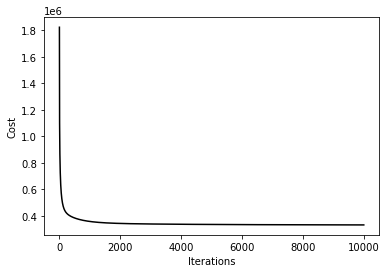

In [71]:
#Loading and processing data
X = df.drop(columns = ['I_O_Sales','I_MRP_JD'])
y = df['I_O_Sales']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Convert Dataframe to numpy array
X_train, y_train, X_test, y_test = np.array(X_train.values), np.array(y_train.values), np.array(X_test.values), np.array(y_test.values)


# Set seed for reproducibility
np.random.seed(0)

degree = 2

# Create the polynomial features
X_train_poly = poly_features(X_train, degree)
X_test_poly = poly_features(X_test, degree)

# Perform gradient descent on the new features
theta = np.random.randn(X_train_poly.shape[1])
theta , cost_history, theta_history = gradient_descent(X_train_poly, y_train, theta, learning_rate, num_iters)

# Make predictions on the test set using the new features
y_pred = predict(X_test_poly, theta)
print("Predictions: ", y_pred)


# Plot the cost over iterations of gradient descent
plt.plot(range(num_iters), cost_history,'k')
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

Model Evaluation for Polynomial Multipule Linear Regression  >>

Mean Absolute Error: 579.8757584999919
Mean Squared Error: 613278.4003316713
Root Mean Squared Error: 783.1209359554061
R-Squared: 0.5647041550125357




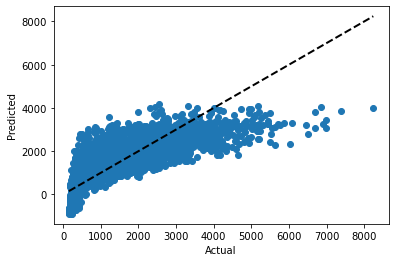

In [72]:
#Calculate evaluation measures
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

#Print the evaluation measures
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Squared:", r2)
print('\n')
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

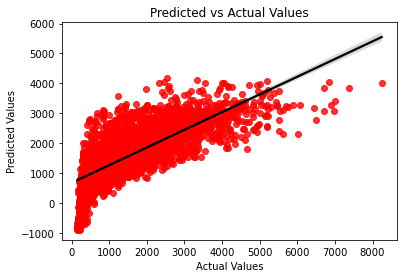

In [73]:
sns.regplot(x = y_test, y = y_pred, scatter_kws={'color':'red'}, line_kws={'color':'black'})
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

In [74]:
df.head()

,Product_category,Product_ID,I_W,I_Fat_C,I_Vis,I_MRP_JD,I_category,I_MRP_US,O_Id,O_Establ_Y,O_Size,I_Recalled,O_Loc_T,O_T,I_O_Sales
0,0.732121,-0.888812,-0.769734,0,-0.970340,1.747351,0.436273,1.747351,0.199488,0.076663,-0.664042,-0.094217,-1.369254,0,2775.832842
1,-0.658301,-1.700653,-1.497397,1,-0.907734,-1.488936,-1.487710,-1.488936,-0.221846,1.541692,-0.664042,10.612577,1.091505,3,442.006765
2,0.836386,-0.888812,0.995602,0,-0.956528,0.010040,-0.189912,0.010040,0.199488,0.076663,-0.664042,-0.094217,-1.369254,0,1614.584430
3,0.377097,-1.352721,1.361586,1,-1.283709,0.660011,0.916923,0.660011,-2.199400,-0.289594,0.799907,-0.094217,1.091505,1,646.877420
4,-2.394902,-0.656858,-0.849389,0,-1.283709,-1.399138,0.659644,-1.399138,0.140549,-1.022108,-2.127990,-0.094217,1.091505,0,832.865987


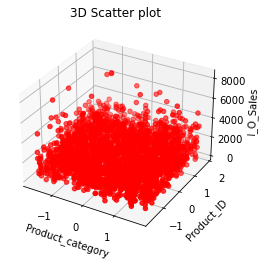

In [75]:
from mpl_toolkits import mplot3d
col = df.columns
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(X_test[:, 1], X_test[:, 2], y_test, c='r', marker='o')
ax.set_xlabel('Product_category')
ax.set_ylabel('Product_ID')
ax.set_zlabel('I_O_Sales')
ax.set_title('3D Scatter plot')
plt.show()


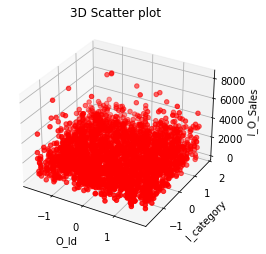

In [76]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_test[:, 1], X_test[:, 2], y_test, c='r', marker='o')
ax.set_xlabel('O_Id')
ax.set_ylabel('I_category')
ax.set_zlabel('I_O_Sales')
ax.set_title('3D Scatter plot')
plt.show()


# KNN

KNN, for classification problem, I evaluate its performance using metrics such as f1 and accuracy.

In [77]:
#Loading and processing data
X = df.drop(columns = ['O_T'])
y = df['O_T']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = np.array(X_train.values)  #The shape of x_train is: (5710, 13)
y_train = np.array(y_train.values)  # The shape of y_train is:  (1, 5710)
X_test = np.array(X_test.values)
y_test = np.array(y_test.values)

#reshape y_train to be a vector of shape (5710,)
y_train = np.squeeze(np.asarray(y_train))


# Define the number of neighbors to consider (K)
K = 3

# Define a function to calculate the Manhattan distance between two points
def manhattan_distance(point1, point2):
    return np.sum(np.abs(point1 - point2))

# Define a function to perform the KNN algorithm
def knn(X_train, y_train, X_test, K):
    # Initialize an empty list to store the predictions
    predictions = []
    
    # Calculate the Manhattan distance between each test example and each training example
    distances = np.sum(np.abs(X_train[np.newaxis, :] - X_test[:, np.newaxis]), axis=2)
    
    # Iterate over each test example
    for i in range(len(X_test)):
        # Sort the distances list in ascending order
        sorted_indices = np.argsort(distances[i])
        
        # Initialize a dictionary to store the frequency of each label
        label_counts = {}
        
        # Iterate over the K nearest neighbors
        for k in range(K):
            # Get the label of the current neighbor
            label = y_train[sorted_indices[k]]
            
            # If the label is already in the dictionary, increment its count
            if label in label_counts:
                label_counts[label] += 1
            # Otherwise, add the label to the dictionary with a count of 1
            else:
                label_counts[label] = 1
        
        # Find the label with the highest frequency
        prediction = max(label_counts, key=label_counts.get)
        
        # Append the prediction to the predictions list
        predictions.append(prediction)
    
    # Return the predictions
    return predictions


predictions = knn(X_train, y_train, X_test, K)

Model Evaluation for  Multipule KNN model >>

In [78]:
# Calculate accuracy
acc = accuracy_score(y_test, predictions)
print("Accuracy >>  ", acc)
print('-'*60)
# Calculate F1 score
f1 = f1_score(y_test, predictions, average='weighted')
print("F1 Score >> ", f1)
print('-'*60)


confu_matrix = confusion_matrix(y_test, predictions)
print("confusion_matrix >>\n", confu_matrix)
print('-'*60)

# Calculate F1 score
classificati = classification_report(y_test, predictions)
print("classification_report >> \n", classificati)

Accuracy >>   0.8666903661571276
------------------------------------------------------------
F1 Score >>  0.8585844922126172
------------------------------------------------------------
confusion_matrix >>
 [[1754   15   45   31]
 [  21  352    1    0]
 [ 114    0  177    2]
 [ 132    8    6  155]]
------------------------------------------------------------
classification_report >> 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      1845
           1       0.94      0.94      0.94       374
           2       0.77      0.60      0.68       293
           3       0.82      0.51      0.63       301

    accuracy                           0.87      2813
   macro avg       0.85      0.75      0.79      2813
weighted avg       0.86      0.87      0.86      2813



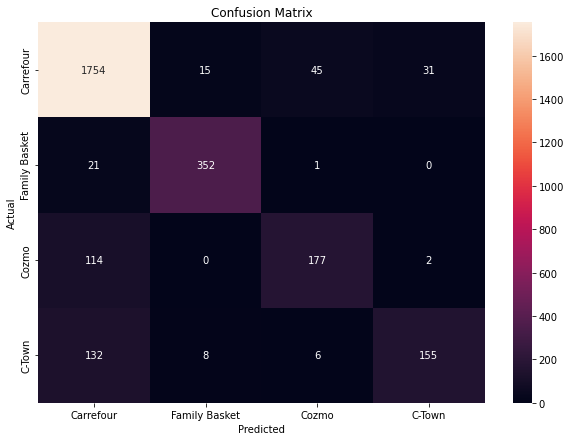

In [79]:
class_names = ['Carrefour', 'Family Basket', 'Cozmo', 'C-Town']
plt.figure(figsize=(10,7))
sns.heatmap(confu_matrix,annot=True,fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The End:)